# Music Recommendation Project

This is the third section of the Capstone Project for Udacity's Machine Learning Engineer Nanodegree.

This notebook includes importing the saved model from the second notebook, evaluating the accuracy on the test set, and saving model metadata and results into a registry.

Author: Ben Walsh \
February 15, 2021

## Contents

1. [Model Import](#model-import)
2. [Evaluate Model](#eval-model)
3. [Saving Results](#save-results)

## <a class="anchor" id="model-import"></a>1. Model Import

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import pickle

import os
import json

Load latest pickled model 

In [2]:
model_folder = './saved_models'
os.listdir(model_folder)

['model-2021-02-06-17-30-53-334642',
 'model-2021-02-07-13-30-55-543499',
 'model-2021-02-07-23-53-6-687154',
 'model-2021-02-08-23-29-3-205832',
 'model-2021-02-11-14-24-33-544871',
 'model-2021-02-11-16-25-48-16993',
 'model-2021-02-11-22-35-57-698187',
 'model-2021-02-14-17-4-45-873407',
 'model-2021-02-15-20-08-5-659642',
 'model-2021-02-15-20-41-44-473217',
 'model-2021-02-15-21-36-33-796540',
 'model-2021-02-15-22-59-17-845109',
 'model-2021-02-16-22-22-48-76',
 'model-2021-02-18-21-55-1-224125',
 'model-history.json']

In [3]:
# load model in pickle
model_folder = './saved_models'
latest_model = os.listdir(model_folder)[-2]
timestamp_str = latest_model.split('model')[-1]
xgb_model = pickle.load(open('{}/{}'.format(model_folder, latest_model), 'rb'))

Import all cleaned feature data: X and y target data for training and testing.

In [4]:
X_train_file = './data-input-clean/X_train.csv'
X_test_file = './data-input-clean/X_test.csv'
y_train_file = './data-input-clean/y_train.csv'
y_test_file = './data-input-clean/y_test.csv'

### Import training/test data

In [5]:
if os.path.exists(X_train_file):
    X_train = pd.read_csv(X_train_file)
else:
    print('Training data file {} not found!'.format(X_train_file))

if os.path.exists(y_train_file):
    y_train = pd.read_csv(y_train_file)
else:
    print('Training data file {} not found!'.format(y_train_file))
    
if os.path.exists(X_test_file):
    X_test = pd.read_csv(X_test_file)
else:
    print('Test data file {} not found!'.format(X_test_file))

if os.path.exists(y_test_file):
    y_test = pd.read_csv(y_test_file)
else:
    print('Test data file {} not found!'.format(y_test_file))

## <a class="anchor" id="eval-model"></a>2. Evaluate Model

Compare training and testing accuracy

In [6]:
y_predict_train = xgb_model.predict(X_train)
y_predict_test = xgb_model.predict(X_test)

In [7]:
# Round outputs to compare
y_predict_train = y_predict_train.round().reshape(len(y_predict_train),1)
y_predict_test = y_predict_test.round().reshape(len(y_predict_test),1)

In [8]:
train_acc = (y_predict_train == y_train.values).sum() / len(y_train)
print('Accuracy on training set = {:.2f}%'.format(100*train_acc))

Accuracy on training set = 63.73%


In [9]:
test_acc = (y_predict_test == y_test.values).sum() / len(y_test)
print('Accuracy on testing set = {:.2f}%'.format(100*test_acc))

Accuracy on testing set = 63.53%


### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

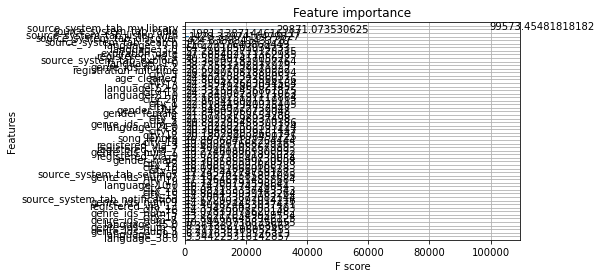

In [10]:
from xgboost import plot_importance
plot_importance(xgb_model, importance_type='gain')

In [11]:
sorted_idx = xgb_model.feature_importances_.argsort()
X_train.columns[sorted_idx]

Index(['registered_via_16', 'language_38.0', 'language_59.0',
       'genre_ids_num_3', 'genre_ids_num_6', 'language_45.0',
       'genre_ids_num_8', 'city_17', 'genre_ids_num_5', 'city_16',
       'registered_via_13', 'genre_ids_num_9',
       'source_system_tab_notification', 'city_15', 'city_10', 'city_21',
       'language_10.0', 'city_19', 'genre_ids_num_7',
       'source_system_tab_settings', 'city_6', 'city_18', 'city_22',
       'gender_male', 'registered_via_9', 'genre_ids_num_1',
       'registered_via_7', 'registered_via_3', 'city_14', 'song_length',
       'city_12', 'city_8', 'language_24.0', 'genre_ids_num_4', 'city_5',
       'city_4', 'gender_female', 'gender_UNK', 'city_9', 'city_1', 'city_20',
       'language_31.0', 'city_11', 'language_52.0', 'city_13', 'city_7',
       'age_cleaned', 'city_3', 'registration_init_time', 'genre_ids_num_2',
       'language_-1.0', 'source_system_tab_explore', 'registered_via_4',
       'expiration_date', 'language_3.0', 'language_17.

### Observations

Initial parameters of XGBoost model without any song features in training data and without any new features has accuracy of 61.69%. The accuracy is nearly identical to the training accuracy, indicating the algorithm is not overfitting.

Second take of XGBoost model with some song features in training data and without any new features has accuracy of 61.81%, which is only a slight improvement. The accuracy is nearly identical to the training accuracy, indicating the algorithm is not overfitting.

Next take attempted to one-hot encode all genres, and simplified to take just the first digit, assuming they were broad categories. Performance dipped slightly to 61.46%. The assumption that they were grouped by first digit is probably wrong.

Next take kept features but increased max depth from 5 to 10. As expected, this increased performance. Test accuracy moderately increased to 62.2%. The next takes will revisit genre ID, and consider other hyper-parameter optimization.

Age input data was cleaned and objective was adjusted to binary:logistic. This actually slightly decreased test accuracy. In the long run this should be better though and more understandable, since any performance gains from latching on to an age value that was negative or over 200 would not scale to new data.

Max depth was increased to 12, balanced by a larger min_child_weight, resulting in record performance (essentially matching the previous high) of 62.2%.

Gender data was included as a feature after a new cleaning step to account for missing values, resulting in record performance of 62.7%. 

City data was one-hot encoded to convert categorical numerical data into separate columns, resulting in record performance of 63.1%.

Registration method was one-hot encoded to convert categorical numerical data into separate columns, which actually lowered performance slightly. Test and training accuracy are nearly identical, indicating the algorithm is not overtraining. Since there are more parameters, I will try allowing the tree to be more complex.

Increasing n_estimators from 10 to 20 nearly matched record performance with 63.0%. Training time is getting noticeably longer, so feature importance will be explored. Training and testing accuracy is still very comparable, so increasing n_estimators may continue to increase performance without overfitting.

Increasing n_estimators, matching max_depth again, and decreasing regularization parameter alpha, resulted in record performance of 63.7%. Training time is taking a long time, so feature importance will be considered. Training and testing accuracy are still very comparable, so increasing n_estimators, max_depth, or lowering alpha further may continue to increase performance without overfitting.

## 6. Save Results

Read model registry and retrieve latest model index

In [12]:
with open('{}/model-history.json'.format(model_folder), 'r') as openfile: 
  
    # Reading from json file 
    model_registry = json.load(openfile) 

model_reg_formatted = json.dumps(model_registry, indent=4, separators=(',', ': '), sort_keys=True)
    
print(model_reg_formatted) 

{
    "0": {
        "data-features": [
            "discover",
            "explore",
            "listen with",
            "my library",
            "notification",
            "radio",
            "search",
            "settings",
            "city",
            "bd",
            "registered_via",
            "registration_init_time",
            "expiration_date"
        ],
        "model-params": {
            "alpha": 10,
            "colsample_bytree": 0.3,
            "learning_rate": 0.1,
            "max_depth": 5,
            "n_estimators": 10,
            "objective": "reg:linear"
        },
        "test-acc": 0.6168999460516007,
        "time": "2021-02-06-17-30-53-334642",
        "train-acc": 0.6166558284115004
    },
    "1": {
        "data-features": [
            "discover",
            "explore",
            "listen with",
            "my library",
            "notification",
            "radio",
            "search",
            "settings",
            "city",
 

In [13]:
# Only taking relevant subset
xgb_hyper_params = {'objective': xgb_model.get_params()['objective'],
                   'colsample_bytree': xgb_model.get_params()['colsample_bytree'],
                   'learning_rate': xgb_model.get_params()['learning_rate'],
                   'max_depth': xgb_model.get_params()['max_depth'],
                   'alpha': xgb_model.get_params()['alpha'],
                   'n_estimators': xgb_model.get_params()['n_estimators']}

new_model_index = np.array(list(model_registry.keys())).astype(int).max() + 1;
new_model_registry_info = { \
    str(new_model_index) : \
   {\
    'time': timestamp_str,
     'data-features': list(X_train.columns.values),
    'model-params': xgb_hyper_params,
    'train-acc': train_acc, 
    'test-acc': test_acc \
    }
  }

Append latest model results and save back to model registry

In [14]:
model_registry.update(new_model_registry_info)

In [15]:
with open('{}/model-history.json'.format(model_folder), 'w') as json_file:
    json.dump(model_registry, json_file)

Print out highest score yet

In [16]:
test_accs = [model_registry[key]['test-acc'] for key in model_registry.keys()]

In [17]:
print('Highest test accuracy = {:.3f} from index = {}'.format(np.max(test_accs), test_accs.index(np.max(test_accs))))

Highest test accuracy = 0.637 from index = 14


Load best model yet and print out parameters

In [45]:
model_key_best = str(test_accs.index(np.max(test_accs)))
xgb_model = pickle.load(open('{}/model{}'.format(model_folder, model_registry[model_key_best]['time']), 'rb'))

In [46]:
xgb_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 12,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1,
 'alpha': 4}